In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
H = np.array([[1.0, 0.0], [0.0, 50.0]])

In [3]:
def cost_func(v):
    return 0.5 * v.T @ H @ v

def gradient(v):
    return H @ v

def gradient_descent(start, alpha, n_iter):
    trajectory = [start.copy()]
    v = start.copy()
    
    for i in range(n_iter):
        grad = gradient(v)
        v = v - alpha * grad
        trajectory.append(v.copy())
        
        if np.linalg.norm(grad) < 1e-6:
            break
    
    return np.array(trajectory)

In [4]:
def newton_method(start, n_iter):
    trajectory = [start.copy()]
    v = start.copy()
    H_inv = np.linalg.inv(H)
    
    for i in range(n_iter):
        grad = gradient(v)
        v = v - H_inv @ grad
        trajectory.append(v.copy())
        
        if np.linalg.norm(grad) < 1e-6:
            break
    
    return np.array(trajectory)

In [5]:
def conjugate_gradient(start, n_iter):
    trajectory = [start.copy()]
    v = start.copy()
    r = -gradient(v)
    p = r.copy()
    
    for i in range(n_iter):
        Ap = H @ p
        alpha = (r.T @ r) / (p.T @ Ap)
        v = v + alpha * p
        trajectory.append(v.copy())
        
        r_new = r - alpha * Ap
        
        if np.linalg.norm(r_new) < 1e-6:
            break
        
        beta = (r_new.T @ r_new) / (r.T @ r)
        p = r_new + beta * p
        r = r_new
    
    return np.array(trajectory)

In [6]:
start_point = np.array([10.0, 10.0])
gd_trajectory = gradient_descent(start_point, alpha=0.02, n_iter=100)
newton_trajectory = newton_method(start_point, n_iter=10)
cg_trajectory = conjugate_gradient(start_point, n_iter=10)

print(f"\nGradient Descent: {len(gd_trajectory)} iterations")
print(f"Newton's Method: {len(newton_trajectory)} iterations")
print(f"Conjugate Gradient: {len(cg_trajectory)} iterations")


Gradient Descent: 101 iterations
Newton's Method: 3 iterations
Conjugate Gradient: 3 iterations


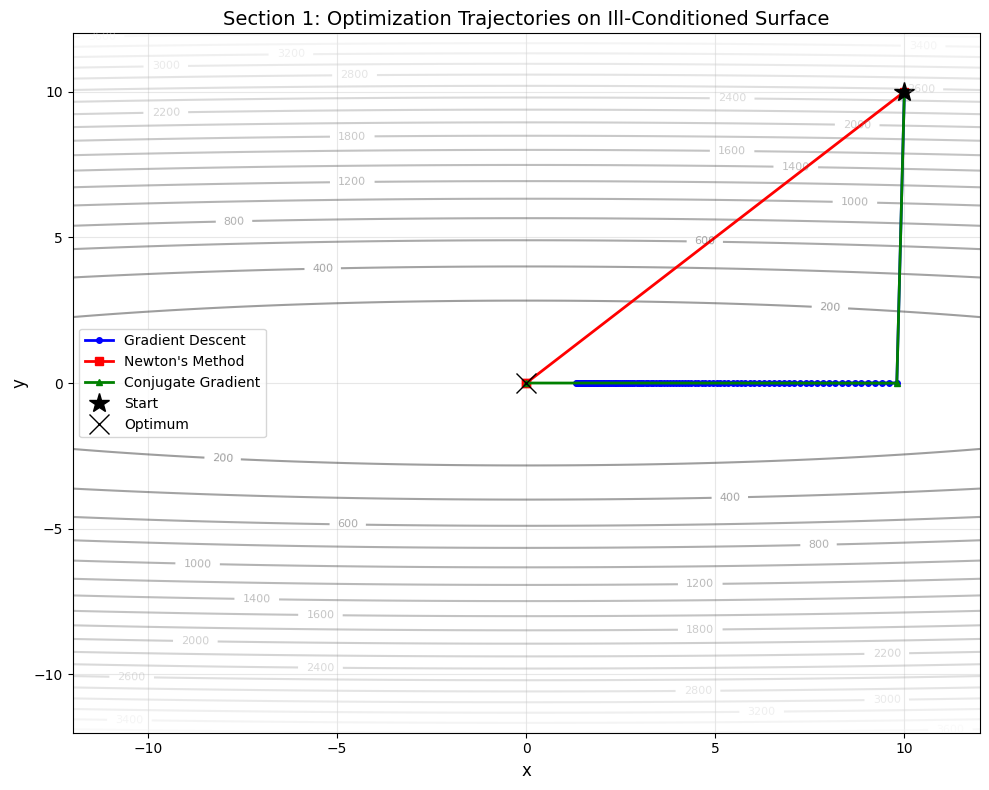

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

x = np.linspace(-12, 12, 400)
y = np.linspace(-12, 12, 400)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        v = np.array([X[i, j], Y[i, j]])
        Z[i, j] = cost_func(v)

contour = ax.contour(X, Y, Z, levels=20, cmap='gray', alpha=0.4)
ax.clabel(contour, inline=True, fontsize=8)

ax.plot(gd_trajectory[:, 0], gd_trajectory[:, 1], 'o-', 
        color='blue', label='Gradient Descent', linewidth=2, markersize=4)
ax.plot(newton_trajectory[:, 0], newton_trajectory[:, 1], 's-', 
        color='red', label="Newton's Method", linewidth=2, markersize=6)
ax.plot(cg_trajectory[:, 0], cg_trajectory[:, 1], '^-', 
        color='green', label='Conjugate Gradient', linewidth=2, markersize=5)

ax.plot(start_point[0], start_point[1], 'k*', markersize=15, label='Start')
ax.plot(0, 0, 'kx', markersize=15, label='Optimum')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Section 1: Optimization Trajectories on Ill-Conditioned Surface', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('section1_trajectories.png', dpi=150, bbox_inches='tight')

In [8]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
X_train_t = torch.FloatTensor(X_train_scaled)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
X_test_t = torch.FloatTensor(X_test_scaled)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1)

In [11]:
class ShallowNet(nn.Module):
    def __init__(self, n_features, n_hidden):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [12]:
n_features = X_train.shape[1]
n_hidden = 5
n_params = (n_features * n_hidden + n_hidden) + (n_hidden * 1 + 1)
print(f"Network: {n_features} -> {n_hidden} -> 1")
print(f"Total parameters: {n_params}")

Network: 30 -> 5 -> 1
Total parameters: 161


In [13]:
def train_model(model, optimizer, X_train, y_train, n_epochs=500):
    criterion = nn.BCELoss()
    losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    return losses

In [14]:
results = {}

model_sgd = ShallowNet(n_features, n_hidden)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.1)
start_time = time.time()
losses_sgd = train_model(model_sgd, optimizer_sgd, X_train_t, y_train_t, n_epochs=500)
sgd_time = time.time() - start_time
results['SGD'] = {'loss_curve': losses_sgd, 'time': sgd_time}
print(f"   Time: {sgd_time:.3f}s, Final loss: {losses_sgd[-1]:.4f}")


   Time: 1.491s, Final loss: 0.0510


In [15]:
model_lbfgs = ShallowNet(n_features, n_hidden)
optimizer_lbfgs = optim.LBFGS(model_lbfgs.parameters(), lr=1.0, max_iter=20)
criterion = nn.BCELoss()
losses_lbfgs = []

start_time = time.time()
for epoch in range(25):
    def closure():
        optimizer_lbfgs.zero_grad()
        outputs = model_lbfgs(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        return loss
    
    loss = optimizer_lbfgs.step(closure)
    losses_lbfgs.append(loss.item())

lbfgs_time = time.time() - start_time
results['L-BFGS'] = {'loss_curve': losses_lbfgs, 'time': lbfgs_time}
print(f"   Time: {lbfgs_time:.3f}s, Final loss: {losses_lbfgs[-1]:.4f}")

   Time: 0.291s, Final loss: 0.0000


In [16]:
model_cg = ShallowNet(n_features, n_hidden)

In [17]:
def get_flat_params(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()]).numpy()

def set_flat_params(model, flat_params):
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        p.data = torch.FloatTensor(flat_params[offset:offset+numel]).view_as(p.data)
        offset += numel

def loss_and_grad_scipy(flat_params):
    set_flat_params(model_cg, flat_params)
    model_cg.zero_grad()
    
    outputs = model_cg(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    
    grad = torch.cat([p.grad.view(-1) for p in model_cg.parameters()]).numpy()
    
    return loss.item(), grad

In [18]:
cg_losses = []
cg_iteration = [0]

In [19]:
def callback_cg(flat_params):
    cg_iteration[0] += 1
    set_flat_params(model_cg, flat_params)
    model_cg.eval()
    with torch.no_grad():
        outputs = model_cg(X_train_t)
        loss = criterion(outputs, y_train_t)
        cg_losses.append(loss.item())

In [20]:
set_flat_params(model_cg, get_flat_params(model_cg))
with torch.no_grad():
    outputs = model_cg(X_train_t)
    initial_loss = criterion(outputs, y_train_t).item()
    cg_losses.append(initial_loss)

In [21]:
start_time = time.time()
init_params = get_flat_params(model_cg)

result = minimize(
    loss_and_grad_scipy, 
    init_params, 
    method='CG',
    jac=True,
    callback=callback_cg,
    options={'maxiter': 500, 'disp': False}
)

cg_time = time.time() - start_time

if not cg_losses:
    set_flat_params(model_cg, result.x)
    with torch.no_grad():
        outputs = model_cg(X_train_t)
        final_loss = criterion(outputs, y_train_t).item()
        cg_losses.append(final_loss)

results['CG'] = {'loss_curve': cg_losses, 'time': cg_time}
print(f"   Time: {cg_time:.3f}s, Final loss: {cg_losses[-1]:.4f}, Iterations: {len(cg_losses)}")


   Time: 0.136s, Final loss: 0.0061, Iterations: 59


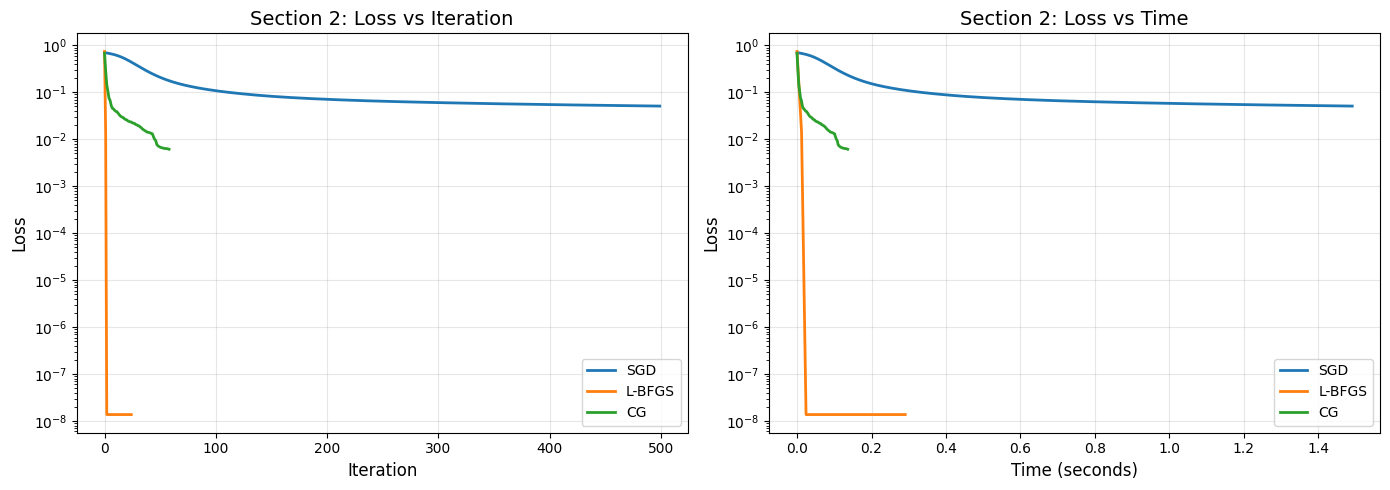

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for name, res in results.items():
    ax1.plot(res['loss_curve'], label=name, linewidth=2)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Section 2: Loss vs Iteration', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

for name, res in results.items():
    time_points = np.linspace(0, res['time'], len(res['loss_curve']))
    ax2.plot(time_points, res['loss_curve'], label=name, linewidth=2)
ax2.set_xlabel('Time (seconds)', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Section 2: Loss vs Time', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('section2_comparison.png', dpi=150, bbox_inches='tight')

In [23]:
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, parser='auto')
X_mnist = fashion_mnist.data[:10000].values / 255.0  # Use subset
y_mnist = fashion_mnist.target[:10000].astype(int).values

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mnist, y_mnist, test_size=0.2, random_state=42
)

In [24]:
X_train_mt = torch.FloatTensor(X_train_m)
y_train_mt = torch.LongTensor(y_train_m)

train_dataset = TensorDataset(X_train_mt, y_train_mt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [25]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [26]:
n_input = 784
n_hidden = 100
n_output = 10
n_params_deep = (
    (n_input * n_hidden + n_hidden) +
    (n_hidden * n_hidden + n_hidden) +
    (n_hidden * n_hidden + n_hidden) +
    (n_hidden * n_output + n_output)
)

hessian_size = n_params_deep ** 2
memory_bytes = hessian_size * 4  # 4 bytes per float32
memory_gb = memory_bytes / (1024 ** 3)

print(f"\nDeep Network: {n_input} -> {n_hidden} -> {n_hidden} -> {n_hidden} -> {n_output}")
print(f"Total parameters: {n_params_deep:,}")
print(f"Hessian matrix size: {n_params_deep:,} × {n_params_deep:,} = {hessian_size:,} elements")
print(f"Memory required: {memory_gb:.2f} GB")



Deep Network: 784 -> 100 -> 100 -> 100 -> 10
Total parameters: 99,710
Hessian matrix size: 99,710 × 99,710 = 9,942,084,100 elements
Memory required: 37.04 GB


In [27]:
def train_deep(model, optimizer, train_loader, n_epochs=20):
    criterion = nn.CrossEntropyLoss()
    losses = []
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
    
    return losses

deep_results = {}

In [28]:
model_sgd_deep = DeepNet()
optimizer_sgd_deep = optim.SGD(model_sgd_deep.parameters(), lr=0.01, momentum=0.9)
start_time = time.time()
losses_sgd_deep = train_deep(model_sgd_deep, optimizer_sgd_deep, train_loader, n_epochs=30)
sgd_deep_time = time.time() - start_time
deep_results['SGD+Momentum'] = {'loss_curve': losses_sgd_deep, 'time': sgd_deep_time}
print(f"Time: {sgd_deep_time:.2f}s, Final loss: {losses_sgd_deep[-1]:.4f}")

Time: 8.16s, Final loss: 0.2188


In [29]:
model_adam_deep = DeepNet()
optimizer_adam_deep = optim.Adam(model_adam_deep.parameters(), lr=0.001)
start_time = time.time()
losses_adam_deep = train_deep(model_adam_deep, optimizer_adam_deep, train_loader, n_epochs=30)
adam_deep_time = time.time() - start_time
deep_results['Adam'] = {'loss_curve': losses_adam_deep, 'time': adam_deep_time}
print(f"Time: {adam_deep_time:.2f}s, Final loss: {losses_adam_deep[-1]:.4f}")

Time: 11.70s, Final loss: 0.1344


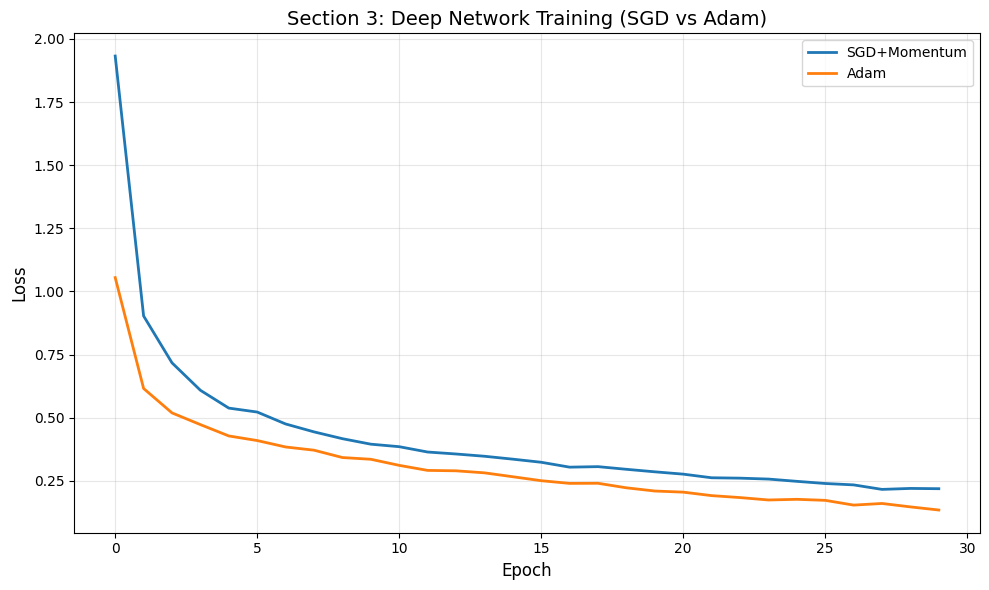

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for name, res in deep_results.items():
    ax.plot(res['loss_curve'], label=name, linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Section 3: Deep Network Training (SGD vs Adam)', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('section3_deep_network.png', dpi=150, bbox_inches='tight')

In [31]:
np.random.seed(42)
n_samples = 500
n_features = 10

In [32]:
base = np.random.randn(n_samples, 3)
X_corr = np.zeros((n_samples, n_features))
X_corr[:, 0] = base[:, 0]
X_corr[:, 1] = 0.9 * base[:, 0] + 0.1 * np.random.randn(n_samples)
X_corr[:, 2] = 0.8 * base[:, 0] + 0.2 * np.random.randn(n_samples)
X_corr[:, 3] = base[:, 1]
X_corr[:, 4] = 0.85 * base[:, 1] + 0.15 * np.random.randn(n_samples)
X_corr[:, 5] = base[:, 2]
X_corr[:, 6] = 0.75 * base[:, 2] + 0.25 * np.random.randn(n_samples)
X_corr[:, 7:] = np.random.randn(n_samples, 3) * 0.5

true_coef = np.random.randn(n_features)
y_corr = X_corr @ true_coef + 0.5 * np.random.randn(n_samples)

scaler_corr = StandardScaler()
X_corr_scaled = scaler_corr.fit_transform(X_corr)

corr_matrix = np.corrcoef(X_corr_scaled.T)

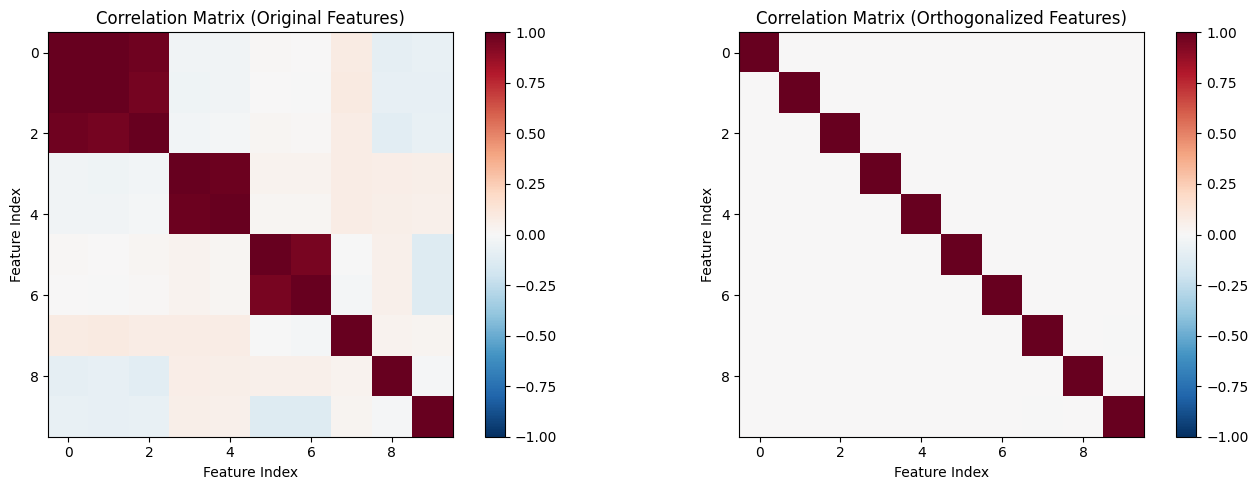

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

im1 = ax1.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('Correlation Matrix (Original Features)', fontsize=12)
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Feature Index')
plt.colorbar(im1, ax=ax1)

# QR Decomposition
Q, R = np.linalg.qr(X_corr_scaled)
Q_features = Q[:, :n_features]  # Use first n_features columns

# Compute correlation of orthogonalized features
corr_matrix_Q = np.corrcoef(Q_features.T)

im2 = ax2.imshow(corr_matrix_Q, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Correlation Matrix (Orthogonalized Features)', fontsize=12)
ax2.set_xlabel('Feature Index')
ax2.set_ylabel('Feature Index')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.savefig('section4_correlation.png', dpi=150, bbox_inches='tight')

In [34]:
def sgd_regression(X, y, lr=0.01, n_iter=200, batch_size=32):
    n_samples, n_features = X.shape
    weights = np.random.randn(n_features) * 0.01
    bias = 0
    losses = []
    
    for epoch in range(n_iter):
        # Shuffle data
        idx = np.random.permutation(n_samples)
        X_shuffled = X[idx]
        y_shuffled = y[idx]
        
        epoch_loss = 0
        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            y_pred = X_batch @ weights + bias
            loss = np.mean((y_pred - y_batch) ** 2)
            epoch_loss += loss
            
            grad_w = 2 * X_batch.T @ (y_pred - y_batch) / len(y_batch)
            grad_b = 2 * np.mean(y_pred - y_batch)
            
            weights -= lr * grad_w
            bias -= lr * grad_b
        
        losses.append(epoch_loss / (n_samples // batch_size))
    
    return losses

In [35]:
losses_raw = sgd_regression(X_corr_scaled, y_corr, lr=0.01, n_iter=200)

In [36]:
losses_ortho = sgd_regression(Q_features, y_corr, lr=0.01, n_iter=200)

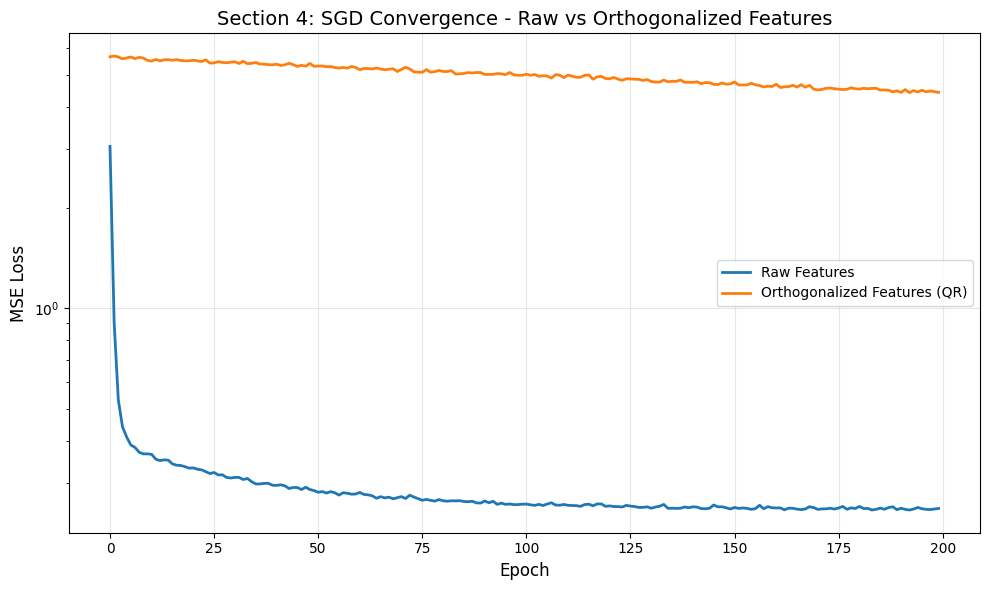

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(losses_raw, label='Raw Features', linewidth=2)
ax.plot(losses_ortho, label='Orthogonalized Features (QR)', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Section 4: SGD Convergence - Raw vs Orthogonalized Features', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('section4_sgd_comparison.png', dpi=150, bbox_inches='tight')